In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.datasets import ImageFolder

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid
import random

In [2]:
device = torch.device('cuda')

manualSeed = 458
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

In [ ]:
n_epochs = 200
lr = 0.0002
batch_size = 32

# Параметры для Adam-оптимизатора
b1 = 0.5
b2 = 0.999

# Размер вектора случайного шума для генератора
latent_dim = 100

# Размер выходных изображений (64x64)
img_size = 64
# 3 канала (цветные изображения)
channels = 3

img_shape = (channels, img_size, img_size)

In [ ]:
# инициализирует веса нейронов для сверточных и нормализационных слоев, что помогает стабилизировать обучение
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator создает изображение из случайного шума
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Первый транспонированный сверточный слой
            nn.ConvTranspose2d(latent_dim, 64*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            # Второй транспонированный сверточный слой, уменьшает глубину и увеличивает размер
            nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            
            # Третий транспонированный сверточный слой
            nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            
            # Четвертый транспонированный сверточный слой
            nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # Финальный транспонированный слой, который выводит изображение с количеством каналов, равным channels
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh() # Применяем Tanh для нормализации значений в диапазон [-1, 1]
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False), # Свертка 4x4, уменьшает размер, увеличивая глубину
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU для слабой активации отрицательных значений
            
            nn.Conv2d(64, 64*2, 4, 2, 1, bias=False), # Глубина 128
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False), # Uke,byf 256
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False), # 512
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64*8, 1, 4, 1, 0, bias=False), # Преобразование в один канал для вероятности
            nn.Sigmoid() # Сигмоида для получения вероятности в диапазоне [0, 1]
        )


    def forward(self, img):
        return self.model(img) # Возвращаем результат последовательной модели

In [7]:
generator = Generator().to(device)
generator.apply(weights_init)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [18]:
from torchvision import transforms

real_data = torch.utils.data.DataLoader(
    ImageFolder("Data", transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
    ])),
    num_workers=2,
    batch_size=batch_size,
    shuffle=True,
)

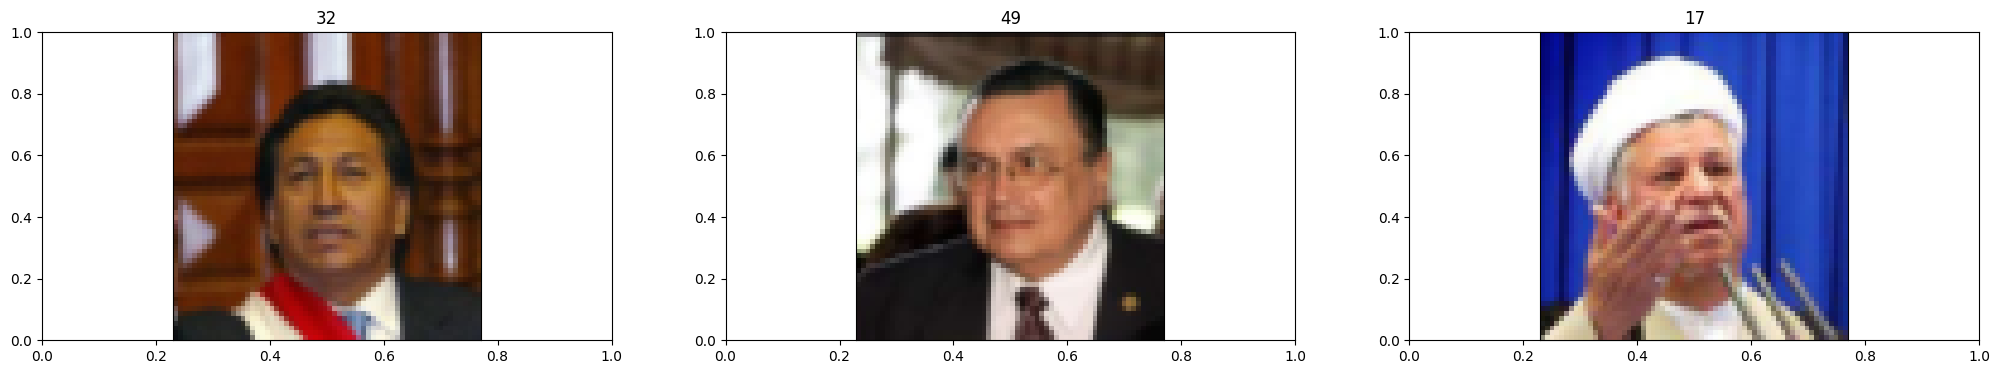

In [19]:
dataiter = iter(real_data)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
ax1, ax2, ax3 = fig.subplots(1, 3)
for idx in np.arange(3):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(str(labels[idx].item()))

In [ ]:
d_loss_history = []
g_loss_history = []
img_list = []

sample_noise = torch.randn(64, latent_dim, 1, 1, device=device) # Образец шума для генерации изображений

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

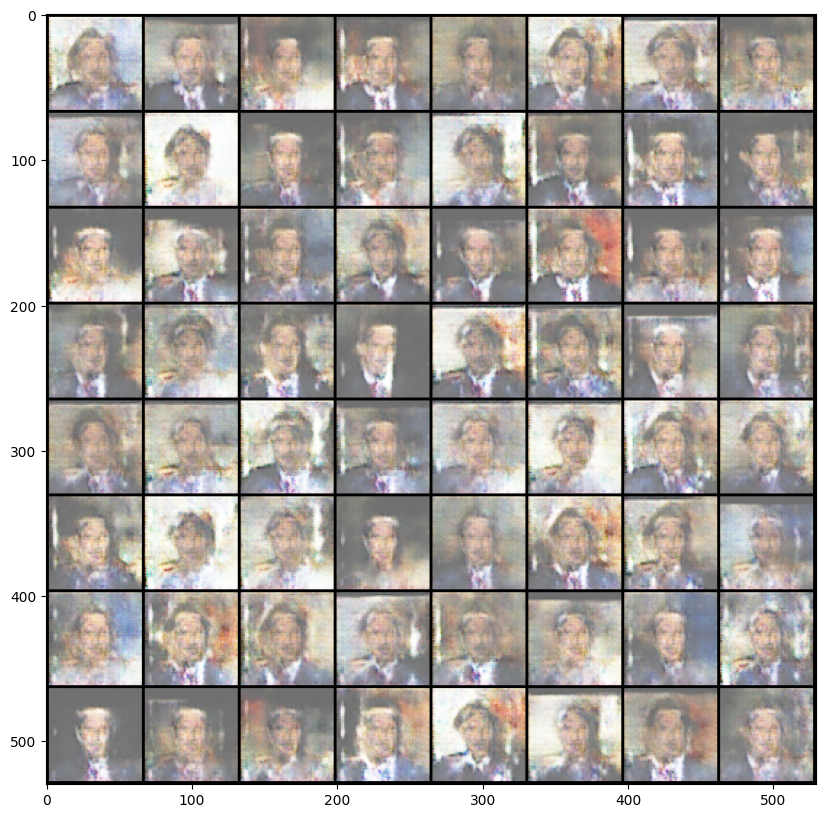

[199/200][0/7]	Loss_D: 0.07230424135923386	Loss_G: 7.94972562789917


In [ ]:
generator.train()
discriminator.train()

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data): # Цикл по батчам в наборе данных
        discriminator.zero_grad()
        real_imgs = Variable(imgs).to(device)
        b_size = real_imgs.size(0) # Размер текущего батча
        label = torch.full((b_size,), 1, device=device, dtype=torch.float) # Метки "1" для реальных изображений
        output = discriminator(real_imgs).view(-1) # Прогноз дискриминатора для реальных изображений
        loss_d_real = adversarial_loss(output, label) # Потери на реальных
        loss_d_real.backward()
        
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device) # Генерация шума
        fake = generator(noise) # Генерация изображения по шуму
        label.fill_(0) # Метки "0" для фейковых изображений
        output = discriminator(fake.detach()).view(-1) # Прогноз дискриминатора для фейковых изображений
        loss_d_fake = adversarial_loss(output, label) # Потери на фейках
        loss_d_fake.backward()
        
        loss_d = loss_d_real + loss_d_fake
        optimizer_D.step()
        
        generator.zero_grad()
        label.fill_(1) # Метки "1" для сгенерированных изображений (чтобы обмануть дискриминатор)
        output = discriminator(fake).view(-1) # Прогноз дискриминатора для фейковых изображений
        loss_g = adversarial_loss(output, label) # Потери генератора (желание дискриминатора принять фейк за реальность)
        loss_g.backward()
        optimizer_G.step() # Обновление весов
        
        if i % 50 == 0: # Выводим каждые 50 логов
            d_loss_history.append(loss_d.item())
            g_loss_history.append(loss_g.item())
            with torch.no_grad():
                fake = generator(sample_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.figure(figsize=(10, 10))
            plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
            plt.show()
            print(f'[{epoch}/{n_epochs}][{i}/{len(real_data)}]\tLoss_D: {loss_d.item()}\tLoss_G: {loss_g.item()}')

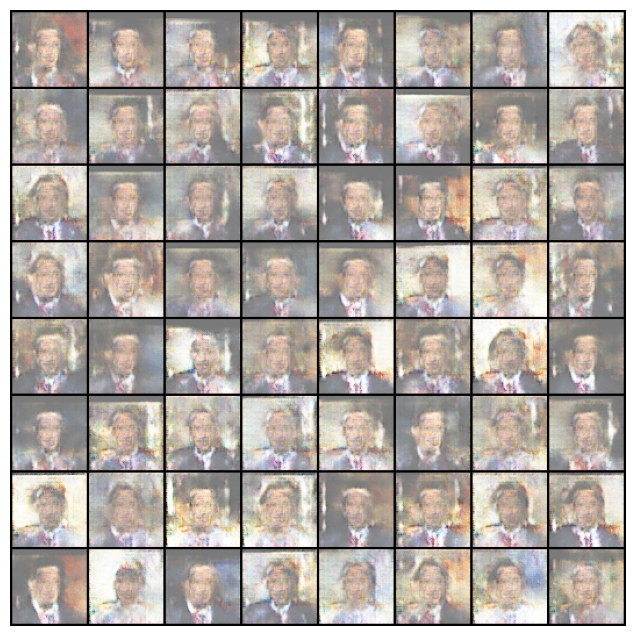

In [ ]:
generator.eval()

z = torch.randn(64, latent_dim, 1, 1, device=device) 
gen_imgs = generator(z).detach().cpu()
img_list.append(make_grid(gen_imgs, padding=2, normalize=True))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()